In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Concatenate, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau, Callback
from keras.regularizers import l2
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [ ]:
def load_data(csv_file):
    df = pd.read_csv(csv_file)
    text1 = df['paragraph1'].values
    text2 = df['paragraph2'].values
    labels = df['change'].values
    return text1, text2, labels

def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def prepare_embedding_matrix(word_index, embeddings_index, EMBEDDING_DIM=50):
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def preprocess_texts(texts1, texts2, tokenizer, max_len=None):
    sequences1 = tokenizer.texts_to_sequences(texts1)
    sequences2 = tokenizer.texts_to_sequences(texts2)
    if not max_len:
        max_len = max(max(len(seq) for seq in sequences1), max(len(seq) for seq in sequences2))
    data1 = pad_sequences(sequences1, maxlen=max_len)
    data2 = pad_sequences(sequences2, maxlen=max_len)
    return data1, data2, max_len

def build_model(input_shape, embedding_matrix):
    input1 = Input(shape=(input_shape,))
    input2 = Input(shape=(input_shape,))

    shared_embedding = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                 weights=[embedding_matrix], trainable=False)

    embedded1 = shared_embedding(input1)
    embedded2 = shared_embedding(input2)

    lstm1 = LSTM(128, kernel_regularizer=l2(0.01))(embedded1)
    lstm2 = LSTM(128, kernel_regularizer=l2(0.01))(embedded2)

    concatenated = Concatenate()([lstm1, lstm2])
    x = Dropout(0.7)(concatenated)
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.summary()
    return model

class F1ScoreCallback(Callback):
    def __init__(self, train_data, validation_data):
        super(F1ScoreCallback, self).__init__()
        self.train_data = train_data
        self.validation_data = validation_data
        self.train_f1s = []
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0])) > 0.5).astype(int)
        val_targ = self.validation_data[1]
        val_f1 = f1_score(val_targ, val_predict)
        self.val_f1s.append(val_f1)

        train_predict = (np.asarray(self.model.predict(self.train_data[0])) > 0.5).astype(int)
        train_targ = self.train_data[1]
        train_f1 = f1_score(train_targ, train_predict)
        self.train_f1s.append(train_f1)

        print(f'— val_f1: {val_f1} — train_f1: {train_f1}')

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 393)]                0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 393)]                0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 393, 50)              1915000   ['input_13[0][0]',            
                                                                     'input_14[0][0]']            
                                                                                                  
 lstm_12 (LSTM)              (None, 128)                  91648     ['embedding_6[0][0]']   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


685/685 [==============================] - 7s 11ms/step
— val_f1: 0.7481688175793513 — train_f1: 0.745072225269702
2739/2739 [==============================] - 105s 37ms/step - loss: 0.6514 - accuracy: 0.6589 - val_loss: 0.5706 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 2/5
685/685 [==============================] - 8s 12ms/step
— val_f1: 0.772767990444909 — train_f1: 0.7710581138646186
2739/2739 [==============================] - 99s 36ms/step - loss: 0.6305 - accuracy: 0.6582 - val_loss: 0.5919 - val_accuracy: 0.6686 - lr: 0.0010
Epoch 3/5
685/685 [==============================] - 8s 12ms/step
— val_f1: 0.7732297579922318 — train_f1: 0.7710543508695518
2739/2739 [==============================] - 100s 37ms/step - loss: 0.6658 - accuracy: 0.6324 - val_loss: 0.6491 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 4/5
  4/144 [..............................] - ETA: 2s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


685/685 [==============================] - 7s 10ms/step
— val_f1: 0.773474001507159 — train_f1: 0.769351645243408
2739/2739 [==============================] - 104s 38ms/step - loss: 0.6113 - accuracy: 0.6529 - val_loss: 0.5647 - val_accuracy: 0.6727 - lr: 0.0010
Epoch 5/5
  6/144 [>.............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


685/685 [==============================] - 8s 12ms/step
— val_f1: 0.7712574850299401 — train_f1: 0.769187587712459
685/685 [==============================] - 8s 12ms/step


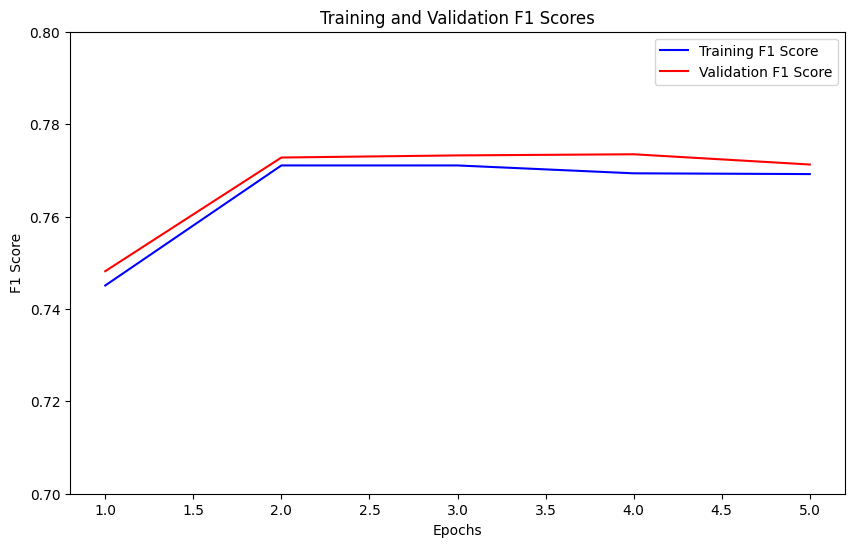

F1 Score on Training Set: 0.769187587712459
F1 Score on Validation Set: 0.7712574850299401


In [ ]:
def compile_and_train(model, X_train1, X_train2, y_train, X_val1, X_val2, y_val):
    f1_callback = F1ScoreCallback(train_data=([X_train1, X_train2], y_train), validation_data=([X_val1, X_val2], y_val))

    callbacks = [
        ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_loss', mode='min'),
        CSVLogger('training_log.csv'),
        EarlyStopping(monitor='val_loss', patience=30, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001),
        f1_callback
    ]

    history = model.fit([X_train1, X_train2], y_train, validation_data=([X_val1, X_val2], y_val), epochs=5, batch_size=8, callbacks=callbacks)

    model.load_weights('model_best.h5')

    val_preds = (model.predict([X_val1, X_val2]) > 0.5).astype(int)
    val_f1 = f1_score(y_val, val_preds)

    train_preds = (model.predict([X_train1, X_train2]) > 0.5).astype(int)
    train_f1 = f1_score(y_train, train_preds)

    # Plotting F1 scores
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(f1_callback.train_f1s) + 1)
    plt.plot(epochs, f1_callback.train_f1s, 'b-', label='Training F1 Score')
    plt.plot(epochs, f1_callback.val_f1s, 'r-', label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.ylim(0.700, 0.800)  # Set the y-axis limit
    plt.title('Training and Validation F1 Scores')
    plt.legend()
    plt.show()

    return train_f1, val_f1


def main(train_csv, glove_file, val_csv):
    tokenizer = Tokenizer(num_words=10000)

    train_text1, train_text2, train_labels = load_data(train_csv)
    val_text1, val_text2, val_labels = load_data(val_csv)

    tokenizer.fit_on_texts(list(train_text1) + list(train_text2) + list(val_text1) + list(val_text2))

    max_len = max([
        len(s) for s in tokenizer.texts_to_sequences(list(train_text1) + list(train_text2) +
                                                     list(val_text1) + list(val_text2))
    ])

    train_sequences1, train_sequences2, _ = preprocess_texts(train_text1, train_text2, tokenizer, max_len)
    val_sequences1, val_sequences2, _ = preprocess_texts(val_text1, val_text2, tokenizer, max_len)

    embeddings_index = load_glove_embeddings(glove_file)
    embedding_matrix = prepare_embedding_matrix(tokenizer.word_index, embeddings_index)

    model = build_model(max_len, embedding_matrix)
    train_f1, val_f1 = compile_and_train(model, train_sequences1, train_sequences2, train_labels,
                                         val_sequences1, val_sequences2, val_labels)

    print(f'F1 Score on Training Set: {train_f1}')
    print(f'F1 Score on Validation Set: {val_f1}')

if __name__ == "__main__":
    main('/content/train.csv', 'glove.6B.50d.txt', '/content/val.csv')